# **1) Import the Modules**

Modules are code libraries that contain a set of ready-to-use functions.

* The `ee` module allows developers to interact with Google Earth Engine using the Python programming language.
* The `os` module provides functions to perform tasks such as file and directory operations, process management, and environment variable manipulation.
* The `json` module allows developers to load, read and write JSON files.
* The `yaml` module allows developers to load, read and write YAML files.
* The `geemap` module allows interactive analysis and visualization of GEE datasets in a Jupyter environment.
* The `matplotlib.pyplot` module provides a collection of functions for creating and customizing plots, diagrams and visualizations.
* The `google.colab` module provides access to some of the unique features and functionality of Google Colab.

In [1]:
!pip install geemap
!pip install ffmpeg-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 7.3 MB/s eta 0:00:00


In [3]:
import ee
import os
import json
import yaml
import geemap
import ffmpeg

import matplotlib.pyplot as plt

from google.colab import drive

***Update the geemap package***

If you encounter errors with this notebook, please remove the comment in the line below to update the geemap package to the latest version from GitHub. Restart the Kernel (Menu -> Kernel -> Restart) to take effect.

In [ ]:
# geemap.update_package()

# **2) Authentication Procedure**

This section provides instructions for setting up the Google Earth Engine Python API on Colab and for setting up Google Drive on Colab. These steps should be performed each time you start/restart/rollback a Colab session.

## **2.1) GEE**

The `ee.Authenticate` function authenticates access to the Google Earth Engine servers, while the `ee.Initialize` function initializes it. After executing the following cell, the user is prompted to grant Google Earth Engine access to their Google account.

**Note:** The Earth Engine API is installed by default in Google Colaboratory.

In [4]:
ee.Authenticate()
ee.Initialize(project="...")

## **2.2) GD**

The `drive.mount` function allows access to specific folders of Google Drive. Granting access to Google Drive allows code running in the notebook to modify files in Google Drive.

**Note:** When using the `Mount Drive` button in the file browser, no authentication codes are required for notebooks edited only by the current user.

In [5]:
drive.mount("/content/gdrive")

Mounted at /content/gdrive


# **3) Functions**

Data Visualization

In [6]:
def plot_data_availability(dct):
  """
  Description:
    Plots the availability of products. This function generates a bar chart that visualizes the
    availability of products based on acquisition dates. The x-axis represents the acquisition
    dates, and the y-axis represents the multitude of images available for each date.

  Parameters:
    acquisitions (list): A list of acquisition dates.
    multiplicity (list): A list of corresponding image multiplicities for each acquisition date.

  Returns:
    None, displays the bar chart showing data availability.
  """
  # Extract keys and values from the dictionary.
  features = list(dct.keys())
  values = list(dct.values())

  # Set up the figure and axis.
  fig, ax = plt.subplots(figsize=(8, 6))

  # Set the color inside the plot behind the bars.
  ax.set_facecolor("lightgray")

  # Create the bar plot.
  plt.bar(features, values)

  # Set plot title and axis labels.
  plt.title("Products Multitude")
  plt.xlabel("Dates")
  plt.ylabel("Acquisitions")

  # Rotate x-axis labels for better readability.
  plt.xticks(rotation=45, ha="right")

  # Add numeric values on top of the bars
  for i, v in enumerate(values):
    plt.text(i, v, str(round(v, 3)), ha="center", va="bottom")

  plt.grid(color="white", linestyle="--", linewidth=0.5)

  # Save the correlation matrix plot
  plt.show()
  plt.close()

# **4) Parameters**

In [ ]:
# `Sentinel-1 GRD`
b1 = "VV"
b2 = "VH"

startDate = "2023-08-30"
endDate = "2023-09-26"

orbitNumbers = [7, 80, 102, 175]

# EMS case of interest.
caseCode = "emsr692"
caseArea = "magnesia"

# GD paths
destinationPath = f"..."

configFile = "..."

# **5) Configuration**

In [ ]:
# `Sentinel-1 GRD`
config = {
  "name": "COPERNICUS/S1_GRD",
  "mode": "IW",
  "resolution": 10,
  "bands": ["VV", "VH"],
  "polarization": ["VV", "VH"],
  "ascendingPass": "ASCENDING",
  "descendingPass": "DESCENDING",
}

visualization = {
  "min": [-25, -25, 0],
  "max": [0, 0, 2],
  "bands": ["VV", "VH", "VVVHQ"]
}

bandCombinations = {
  "sum": {
    "expression": "b('b1') + b('b2')",
    "name": "b1b2S"
  },
  "difference": {
    "expression": "b('b1') - b('b2')",
    "name": "b1b2D"
  },
  "product": {
    "expression": "b('b1') * b('b2')",
    "name": "b1b2P"
  },
  "quotient": {
    "expression": "b('b1') / b('b2')",
    "name": "b1b2Q"
  }
}

In [ ]:
# Parse the approprieate configuration file.
extension = os.path.splitext(configFile)[-1]

try:
  with open(configFile, "r") as stream:
    # JSON configuration file
    if extension == ".json":
      caseConfigurations = json.load(stream)

    # YAML configuration file
    if extension == ".yaml":
      caseConfigurations = yaml.safe_load(stream)

except FileNotFoundError as e:
  print(f"Error: JSON file not found: {e}")

# Retrieve configurations.
caseConfig = caseConfigurations[caseCode][caseArea]

# Retrieve GEE assets.
areaOfInterest = ee.FeatureCollection(caseConfig["area_of_interest"])

# **6) Data Processing**

Engineer additional raster bands.

In [ ]:
# `VVVHQ`
quotientName = bandCombinations["quotient"]["name"].replace("b1", b1).replace("b2", b2)
quotientFormula = bandCombinations["quotient"]["expression"].replace("b1", b1).replace("b2", b2)

Load, filter and process raster collections.

In [ ]:
# `Sentinel-1 GRD`
collection = ee.ImageCollection(config["name"])                                       \
  .filterDate(startDate, endDate)                                                     \
  .filterBounds(areaOfInterest)                                                       \
  .select(config["bands"])                                                            \
  .filter(ee.Filter.eq("instrumentMode", config["mode"]))                             \
  .filter(ee.Filter.eq("resolution_meters", config["resolution"]))                    \
  .filter(ee.Filter.inList("relativeOrbitNumber_start", orbitNumbers))                \
  .filter(ee.Filter.eq("transmitterReceiverPolarisation", config["polarization"]))    \
  .map(lambda raster: raster.set("acquisition", raster.date().format("YYYY-MM-dd")))  \
  .map(lambda raster: raster.addBands(raster.expression(quotientFormula).rename(quotientName)))

# Segment the collection into 'ascending' and 'descending' orbit sub-collections.

# `Ascending`
ascCollection = collection.filter(ee.Filter.eq("orbitProperties_pass", config["ascendingPass"]))

# `Descending`
descCollection = collection.filter(ee.Filter.eq("orbitProperties_pass", config["descendingPass"]))

# Extract collection statistics.

# `Ascending`
ascHistogram = ascCollection.aggregate_histogram("acquisition")
ascAcquisitions = ascHistogram.keys().getInfo()
ascMultiplicity = ascHistogram.values().getInfo()

# `Descending`
descHistogram = descCollection.aggregate_histogram("acquisition")
descAcquisitions = descHistogram.keys().getInfo()
descMultiplicity = descHistogram.values().getInfo()

# **7) Console**

In [ ]:
print("*Ascending Collection*")
print(f"Total number of products: `{ascCollection.size().getInfo()}`")
print(f"Acquisition dates: `{ascAcquisitions}`")
print(f"Raster identifiers: `{ascCollection.aggregate_array('system:index').getInfo()}`")

print("")

print("*Descending Collection*")
print(f"Total number of products: `{descCollection.size().getInfo()}`")
print(f"Acquisition dates: `{descAcquisitions}`")
print(f"Raster identifiers: `{descCollection.aggregate_array('system:index').getInfo()}`")

*Ascending Collection*
Total number of products: `10`
Acquisition dates: `['2023-08-31', '2023-09-07', '2023-09-12', '2023-09-19', '2023-09-24']`
Raster identifiers: `['S1A_IW_GRDH_1SDV_20230831T163223_20230831T163248_050122_060824_2821', 'S1A_IW_GRDH_1SDV_20230831T163248_20230831T163313_050122_060824_6D18', 'S1A_IW_GRDH_1SDV_20230907T162412_20230907T162437_050224_060B99_D80F', 'S1A_IW_GRDH_1SDV_20230907T162437_20230907T162502_050224_060B99_3635', 'S1A_IW_GRDH_1SDV_20230912T163224_20230912T163249_050297_060E1D_9D5F', 'S1A_IW_GRDH_1SDV_20230912T163249_20230912T163314_050297_060E1D_47AA', 'S1A_IW_GRDH_1SDV_20230919T162412_20230919T162437_050399_061199_0F25', 'S1A_IW_GRDH_1SDV_20230919T162437_20230919T162502_050399_061199_CF8F', 'S1A_IW_GRDH_1SDV_20230924T163224_20230924T163249_050472_061410_B414', 'S1A_IW_GRDH_1SDV_20230924T163249_20230924T163314_050472_061410_B3FB']`

*Descending Collection*
Total number of products: `10`
Acquisition dates: `['2023-09-01', '2023-09-06', '2023-09-13', '2

# **7) Data Visualization**

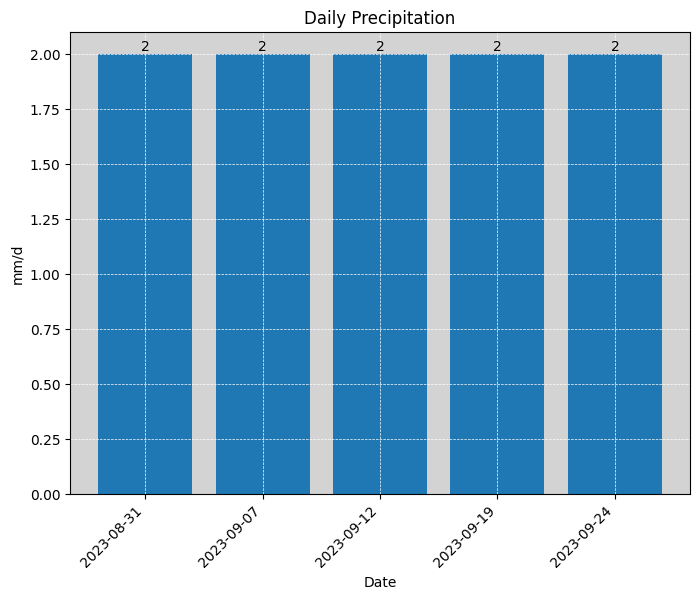

In [ ]:
plot_data_availability(dict(zip(ascAcquisitions, ascMultiplicity)))

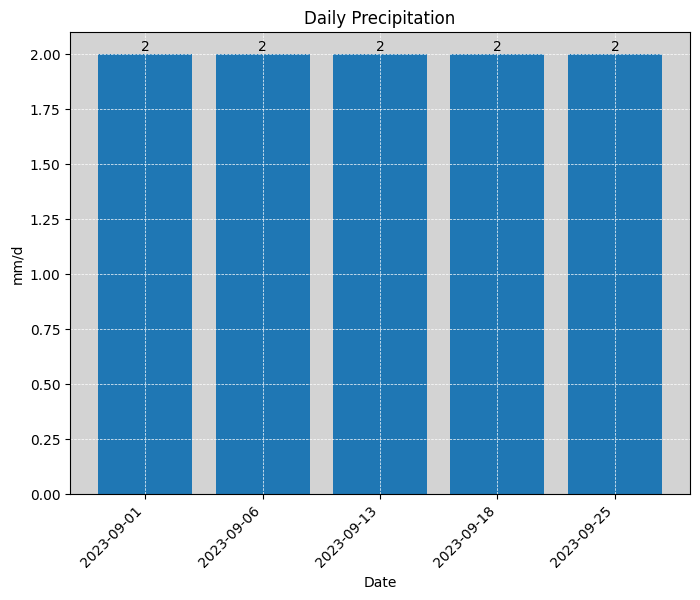

In [ ]:
plot_data_availability(dict(zip(descAcquisitions, ascMultiplicity)))

# **8) Export Timelapses**

In [ ]:
timelapseParameters = {
  "region": areaOfInterest,
  "start_date": startDate,
  "end_date": endDate,
  "frequency": "day",
  "reducer": "mean",
  "vis_params": visualization,
  "frames_per_second": 1,
  "font_size": 35,
}

Ascending

In [ ]:
ascTimelapse = geemap.create_timelapse(
  **timelapseParameters,
  collection = ascCollection,
  text_sequence = ascAcquisitions,
  title = caseArea,
  out_gif = os.path.join(destinationPath, caseCode, caseArea, "timelapses", "sar_asc_timelapse.gif")
)


Generating URL...
Please wait ...
The GIF image has been saved to: /content/gdrive/MyDrive/t-h-e-s-i-s/results/emsr692/magnesia/timelapses/sar_asc_timelapse.gif


In [ ]:
geemap.show_image(ascTimelapse)

Output()

Descending

In [ ]:
descTimelapse = geemap.create_timelapse(
  **timelapseParameters,
  collection = descCollection,
  text_sequence = descAcquisitions,
  title = caseArea,
  out_gif = os.path.join(destinationPath, caseCode, caseArea, "timelapses", "sar_desc_timelapse.gif")
)

Generating URL...
Please wait ...
The GIF image has been saved to: /content/gdrive/MyDrive/t-h-e-s-i-s/results/emsr692/magnesia/timelapses/sar_desc_timelapse.gif


In [ ]:
geemap.show_image(descTimelapse)

Output()

-End of Notebook-